In [707]:
from __future__ import annotations
import numpy as np
import itertools
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd
from scipy.optimize import linprog
from typing import Dict, List, Optional, Tuple, Iterable
from scipy.optimize import linprog
import sys
import os
import matplotlib.pyplot as plt
import time

sys.path.append('../')


# Region class

In [708]:
# Region class as dataclass
class Region:
    def __init__(self, activation=None):
        # Region attributes
        self.qlw = activation # Activation pattern
        self.qlw_tilde = None # Active bits in activation pattern (indices)
        self.bounded = None
        
        # Inequalities and projections
        self.Dlw = None # Slopes of inequalities
        self.glw = None # Intercept of inequalities 
        
        self.Dlw_active = None # Active slopes
        self.glw_active = None # Active intercepts
        
        self.Alw = None # Slope projection matrix
        self.clw = None # Intercept projection matrix
        
        # Tree attributes
        self.parent = None # Parent Region object
        self.children = [] # List of children (Region objects)
        
        # Utility attributed
        self.layer_number = 0 # Layer to which this region belongs
        self.region_index = 0 # Index to identify regions #TODO necessary?

    # def find_active_inequalities(self):
    #     self.Dlw_active = self.Dlw[list(self.qlw_tilde),:]
    #     self.glw_active = self.glw[list(self.qlw_tilde)]
        
    def add_child(self, child):
        child.parent = self
        self.children.append(child)
        
    def is_leaf(self):
        return len(self.children) == 0
    
    def is_root(self):
        return self.parent is None
    
    def get_children(self):
        return self.children
    
    def get_depth(self):
        depth = 0
        node = self
        while node.parent is not None:
            node = node.parent
            depth += 1
        assert depth == self.layer_number, "Depth and layer number are not equal"
        return depth
    
    def get_ancestors(self):
        ancestors = []
        node = self
        
        while node.parent is not None:
            ancestors.append(node.parent)
            node = node.parent
        
        return ancestors[::-1]
    
    # def get_path_inequalitites(self):
    #     # FIXME
    #     inequalities = []
    #     node = self
        
    #     while node.parent is not None:
    #         if node.ineqs is not None:
    #             inequalities.append(node.ineqs)
    #         node = node.parent
            
    #     return np.vstack(inequalities[::-1]) if inequalities else None
        
        

# Logic begin building the tree - first Layer

## Make state dict

In [709]:
# Make a dummy state dict
from src_experiment import NeuralNet

model = NeuralNet(
    input_size = 2,
    hidden_sizes = [5,4,3],
    num_classes=2,
    seed=3,
)
sd = model.state_dict()
sd

OrderedDict([('l1.weight',
              tensor([[-1.7173, -1.3663],
                      [-0.7419, -1.6387],
                      [-0.0983, -1.5238],
                      [ 0.9418,  0.8442],
                      [ 0.3271,  1.3436]])),
             ('l1.bias', tensor([0., 0., 0., 0., 0.])),
             ('l2.weight',
              tensor([[-0.1073,  0.6562, -0.7672, -0.2159, -0.9767],
                      [-0.0889, -0.7107,  0.9841,  0.7609,  0.8213],
                      [ 0.3249, -0.6249,  0.9844, -1.0689, -0.6992],
                      [-0.6842, -0.4541,  0.2184, -0.8298, -0.8439]])),
             ('l2.bias', tensor([0., 0., 0., 0.])),
             ('l3.weight',
              tensor([[-0.5857,  0.7475, -0.8834, -1.0985],
                      [-1.0615, -0.6027, -0.3218, -1.2142],
                      [-0.5734,  0.0236,  0.2019, -0.1756]])),
             ('l3.bias', tensor([0., 0., 0.])),
             ('l4.weight',
              tensor([[-0.1242, -0.7127,  0.5612],
          

## Find the hyperplanes

In [710]:
def find_hyperplanes(state_dict):
    weights = []
    biases = []
    hyperplanes = [] 
    for key, val in state_dict.items():
        if "weight" in key:
            weights.append(val)
        elif "bias" in key:
            biases.append(val)
    for W, b in zip(weights, biases):
        hyperplanes.append(np.hstack((W, b.reshape(-1,1))))
    return hyperplanes
H = find_hyperplanes(sd)

## Extract $W$ and $b$ and find $x_0$ "random" point

In [711]:
# For the first step, the root node is the parent, it should be initializes without an activation pattern

# Root initialization
root = Region()



def get_weigths_and_biases_from_hyperplanes(H, l=1):
    W = H[l-1][:,:-1] # Shape (hl, hl-1)
    b = H[l-1][:,-1].reshape(-1,1) # shape (hl, 1)
    return W, b

# Work with the first layer - regions induced by the first layer of the network
# Weigths and biases of first layer
W1, b1 = get_weigths_and_biases_from_hyperplanes(H, l=1)
print(W1.shape)
print(b1.shape)


m = W1.shape[1] # Dim of input space
A0w = np.eye(m) # Root slope projection matrix
c0w = np.zeros(m).reshape(-1,1) # Root intercept projection matrix

root.Alw = A0w
root.clw = c0w

# "random" point in input space x0 has shape (d_input, 1)
np.random.seed(42)
x0 = np.random.randint(-5,5,size=W1[0,:].shape).reshape(-1,1)
x0

(5, 2)
(5, 1)


array([[ 1],
       [-2]])

## Visualize hyperplanes and points

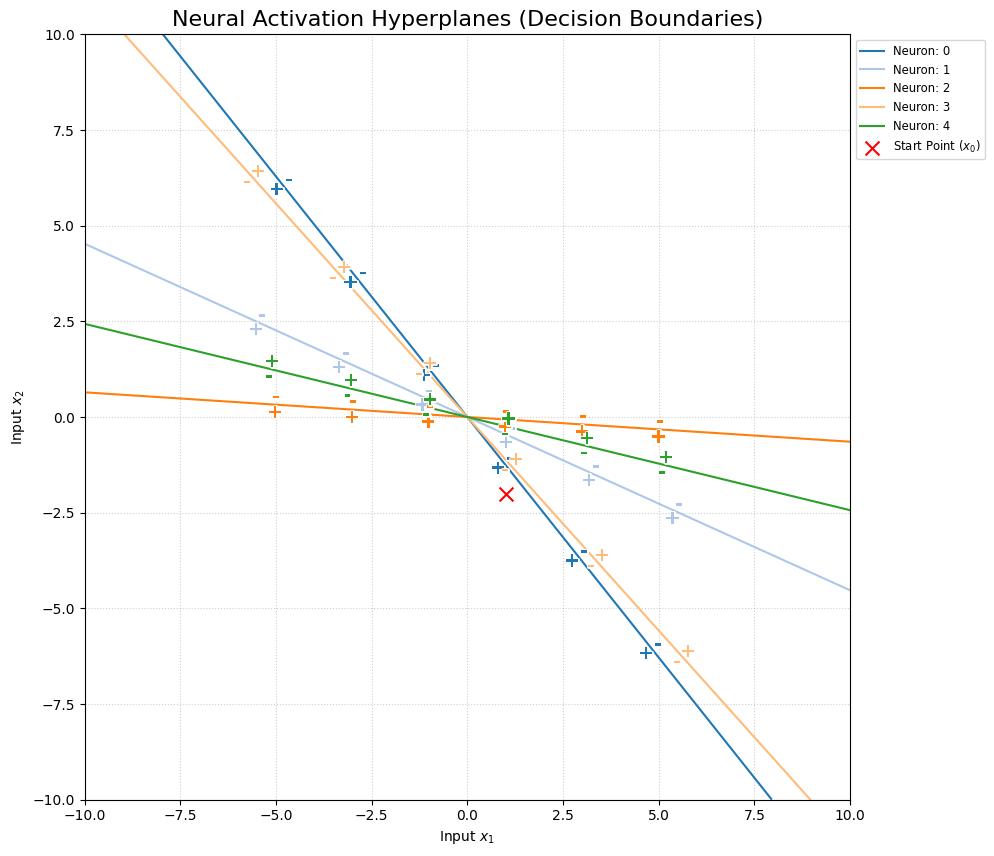

In [712]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from itertools import cycle

# --- 1. Data and State Setup ---

# Using tab20 to get 20 distinct colors before repeating
color_pool = cycle(plt.cm.tab20.colors)

def to_tuple(array):
    """Converts a 1D numpy array to a hashable tuple."""
    return tuple(array.ravel())

# --- 2. Helper Functions ---

def clip_to_bounds(x, y, x_min, x_max, y_min, y_max):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

def plot_hyperplane(ax, w, b, color, label, offset=0.15, num_marks=6, fac=5):
    """Plot a hyperplane with +/- markers showing the activation direction."""
    # Check if the line is not perfectly vertical
    x_min, x_max = -fac, fac
    y_min, y_max = -fac, fac

    if abs(w[1]) > 1e-6:
        x_vals = np.linspace(x_min, x_max, 1000)
        y_vals = -(w[0]*x_vals + b)/w[1]
        mask = (y_vals >= y_min) & (y_vals <= y_max)
        
        if np.any(mask):
            x_line, y_line = x_vals[mask], y_vals[mask]
            ax.plot(x_line, y_line, color=color, label=label, linewidth=1.5)

            # Normal vector for marker direction
            n = w / np.linalg.norm(w)
            
            # Interpolate points along the visible segment for markers
            ds = np.sqrt(np.diff(x_line)**2 + np.diff(y_line)**2)
            s = np.concatenate(([0], np.cumsum(ds)))
            s_targets = np.linspace(s[0] + 5, s[-1] - 5, num_marks)
            x_marks = np.interp(s_targets, s, x_line)
            y_marks = np.interp(s_targets, s, y_line)

            for xm, ym in zip(x_marks, y_marks):
                # Calculate positive and negative side positions
                for sign, direction in [('+', 1), ('-', -1)]:
                    xt, yt = xm + direction * offset * n[0], ym + direction * offset * n[1]
                    if clip_to_bounds(xt, yt, x_min, x_max, y_min, y_max):
                        ax.text(xt, yt, sign, color=color, ha='center', va='center', 
                                fontsize=14, weight='bold',
                                path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    else:
        # Vertical line case (w[1] is 0)
        x_line = -b/w[0]
        if x_min <= x_line <= x_max:
            ax.axvline(x_line, color=color, label=label, linewidth=1.5)
            n = w / np.linalg.norm(w)
            y_marks = np.linspace(y_min + 10, y_max - 10, num_marks)
            for ym in y_marks:
                for sign, direction in [('+', 1), ('-', -1)]:
                    xt = x_line + direction * offset * n[0]
                    if clip_to_bounds(xt, ym, x_min, x_max, y_min, y_max):
                        ax.text(xt, ym, sign, color=color, ha='center', va='center', 
                                fontsize=14, weight='bold',
                                path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# --- 3. Plotting Execution ---

fig, ax = plt.subplots(figsize=(10, 10))
fac = 10
# Iterate through weights and biases to plot hyperplanes
for n, (we, be) in enumerate(zip(W1, b1)):
    # Get a real color from the cycle (Crucial fix)
    current_color = next(color_pool)
    
    # We pass a higher offset (e.g., 4.0) because the coordinate space is 200 units wide
    plot_hyperplane(ax, we, be, color=current_color, label=f"Neuron: {n}", offset=fac/50, fac=fac)

# Mark the specific point x0
ax.scatter(x0[0], x0[1], marker="x", color="red", s=100, label="Start Point ($x_0$)", zorder=5)

# Formatting the plot
ax.set_xlim(-fac, fac)
ax.set_ylim(-fac, fac)
ax.set_aspect('equal')
ax.grid(True, linestyle=':', alpha=0.6)

# Move legend outside if there are many neurons
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', ncol=1)

plt.title("Neural Activation Hyperplanes (Decision Boundaries)", fontsize=16)
plt.xlabel("Input $x_1$")
plt.ylabel("Input $x_2$")
plt.tight_layout()
plt.show()

## Find $q_0$ - activation pattern of $x_0$

In [713]:
def find_activation_pattern(x, Wl, bl, Alw_prev, clw_prev):
    z = Wl @ Alw_prev @ x + Wl @ clw_prev + bl
    return (z>0).astype(int)

q10 = find_activation_pattern(x0, W1, b1, root.Alw, root.clw)
q10

array([[1],
       [1],
       [1],
       [0],
       [0]])

## Find $s_0$ and $S_0$ - sign vector/matrix of $x_0$

In [714]:
# Find sign vector s and sign matrix S = diag(s)
def get_signs_from_activation(activation: np.ndarray) -> np.ndarray:
    """Convert activation vector {0, 1} to sign vector {-1, 1}."""
    return -2 * activation + 1
s10 = get_signs_from_activation(q10)
S10 = np.diag(s10.ravel())

def get_sign_matrix(q):
    s = get_signs_from_activation(q)
    S = np.diag(s.ravel())
    return S

## Find region inequalities - slopes $D$ and intercepts $g$

In [715]:
D10 = S10 @ W1 @ A0w
g10 = -S10 @ (W1 @ c0w + b1)


## Find $\tilde{q_0}$ - Active bits of $q_0$

In [716]:
import numpy as np
from scipy.optimize import linprog
import multiprocessing as mp


def _solve_single_lp(args):
    """
    Tests if a SPECIFIC local constraint i is active GIVEN the global domain.
    """
    target_idx, D_all, g_all, tol, bounds = args
    
    # The direction we want to push to see if we can "cross" this boundary
    d_i = D_all[target_idx]
    
    # We must satisfy ALL constraints EXCEPT the one we are testing
    D_tilde = np.delete(D_all, target_idx, axis=0)
    g_tilde = np.delete(g_all, target_idx, axis=0)

    try:
        res = linprog(
            c=-d_i, # Maximize distance past the boundary
            A_ub=D_tilde,
            b_ub=g_tilde,
            bounds=bounds,
            method="highs",
        )
    except ValueError as e:
        if "HiGHS Status 15" in str(e):
            return target_idx, False 
        raise e

    if res.x is not None:
        val = -res.fun if res.fun is not None else np.dot(d_i, res.x)
        # If we can cross the boundary (val > g[i]), the neighbor is reachable
        if val > g_all[target_idx] + tol:
            return target_idx, True
        return -1, True
    
    elif res.status == 3: # Unbounded past the boundary
        return target_idx, False
    
    return -1, True

def find_active_bits(D_local, g_local, D_global=None, g_global=None, n_jobs=None, tol=1e-7, parallel=False):
    """
    Only solves LPs for local constraints, but uses global constraints as bounds.
    """
    D_local = np.asarray(D_local)
    g_local = np.asarray(g_local).flatten()
    
    
    n_local = D_local.shape[0]
    dim = D_local.shape[1]
    
    # Combine everything for the background constraints
    if D_global is not None and g_global is not None:
        D_global = np.asarray(D_global)
        g_global = np.asarray(g_global).flatten()
        D_all = np.vstack([D_local, D_global])
        g_all = np.concatenate([g_local, g_global])
    else:
        D_all = D_local
        g_all = g_local
    
    bounds = [(None, None)] * dim
    active_local_bits = []
    is_bounded = True
    
    # Only create tasks for the LOCAL indices (0 to n_local - 1)
    tasks = [(i, D_all, g_all, tol, bounds) for i in range(n_local)]
    
    if parallel:
        if n_jobs is None:
            n_jobs = mp.cpu_count()

        with mp.Pool(processes=n_jobs) as pool:
            for k, (res, bounded) in enumerate(pool.imap_unordered(_solve_single_lp, tasks)):
                if res != -1:
                    active_local_bits.append(res)
                if not bounded:
                    is_bounded = False
    else:
        for task in tasks:
            idx, bounded = _solve_single_lp(task)
            if idx != -1:
                active_local_bits.append(idx)
            if not bounded:
                is_bounded = False
                
    return np.array(sorted(active_local_bits)), is_bounded


q0_tilde, bounded = find_active_bits(D10, g10, n_jobs=8)

print(f"q: {tuple(q10.ravel().tolist())}\nq_tilde: {tuple(q0_tilde.ravel().tolist())}\nBounded: {bounded}")

q: (1, 1, 1, 0, 0)
q_tilde: (0, 2)
Bounded: False


## Iterate through active bits and accumulate neighbours

In [717]:
# Create dicts to keep track of the activations. 

traversed = {} # Dictionary of traversed activation patterns
actives = {} # Dictionary with indices of active neurons for each activation

def to_tuple(array):
    return tuple(array.ravel().tolist())

traversed[to_tuple(q10)] = True
actives[to_tuple(q10)] = q0_tilde

In [718]:
# Iterate through and change the actvie indices

for active_idx in q0_tilde:
    q_new = q10.copy()
    q_new[active_idx] ^= 1  # 0 becomes 1, 1 becomes 0
    traversed[to_tuple(q_new)] = False

In [719]:
 # 1. Initialize
traversed = {}
actives = {} # Dictionary with indices of active neurons for each activation
queue = [to_tuple(q10)]
# traversed[to_tuple(q0)] = True

# 2. Process until no new states are found
region_idx = 0
while queue:
    current_key = queue.pop(0)  # Get the next state to process
    current_q = np.array(current_key) 
    
    # Calculate relevant quantities
    S1w = get_sign_matrix(current_q)
    
    # Find inequalities
    local_hyperplane_slopes = W1 @ root.Alw
    local_hyperplane_intercepts = W1 @ root.clw + b1
    D1w = S1w @ local_hyperplane_slopes
    g1w = - S1w @ local_hyperplane_intercepts
    
    # Find active indices
    current_active_indices, bounded = find_active_bits(D1w, g1w, n_jobs=1, parallel=False) 
    actives[current_key] = current_active_indices
    
    # Initialize new region
    new_region = Region(current_q)
    new_region.q_tilde = current_active_indices
    new_region.bounded = bounded
    new_region.Dlw = D1w
    new_region.glw = g1w
    new_region.Dlw_active = D1w[list(current_active_indices),:]
    new_region.glw_active = g1w[list(current_active_indices)]
    # new_region.find_active_inequalities()
    
    # Compute projections for that region
    Q1w = np.diag(current_q.ravel())
    new_region.Alw = Q1w @ local_hyperplane_slopes
    new_region.clw = Q1w @ local_hyperplane_intercepts
    
    # Place region in region tree
    new_region.layer_number = 1
    new_region.region_index = region_idx
    region_idx += 1
    root.add_child(new_region)
    
    print(current_key)
    traversed[current_key] = True
    
    for active_idx in current_active_indices:
        # Generate neighbor
        q_new = current_q.copy()
        q_new[active_idx] ^= 1
        new_key = to_tuple(q_new)
        
        # 3. Only add if we haven't seen it before
        if new_key not in traversed:
            traversed[new_key] = False
            queue.append(new_key)  # Add to queue to be processed in a future loop
            
    # Mark the current one as fully processed
    traversed[current_key] = True

(1, 1, 1, 0, 0)
(0, 1, 1, 0, 0)
(1, 1, 0, 0, 0)
(0, 1, 1, 1, 0)
(1, 1, 0, 0, 1)
(0, 0, 1, 1, 0)
(1, 0, 0, 0, 1)
(0, 0, 1, 1, 1)
(1, 0, 0, 1, 1)
(0, 0, 0, 1, 1)


In [720]:
len(traversed)

10

## Investigate tree

In [721]:
def clip_vertices(vertices, bound):
    clipped_vertices = []
    for i in range(len(vertices)):
        curr_vertex = vertices[i]
        next_vertex = vertices[(i + 1) % len(vertices)]  # Get the next vertex (wraps around to the first vertex)
        
        x1, y1 = curr_vertex[0], curr_vertex[1]
        x2, y2 = next_vertex[0], next_vertex[1]

        # Check if the line segment intersects with the boundaries
        if (-bound <= x1 <= bound and -bound <= y1 <= bound):
            clipped_vertices.append(curr_vertex)

        # Check if the line segment intersects with the x-axis boundaries
        if (y1 < -bound and y2 > -bound) or (y1 > -bound and y2 < -bound):
            intersect_x = x1 + ((-bound - y1) * (x2 - x1)) / (y2 - y1)
            if -bound <= intersect_x <= bound:
                clipped_vertices.append([intersect_x, -bound])

        if (y1 < bound and y2 > bound) or (y1 > bound and y2 < bound):
            intersect_x = x1 + ((bound - y1) * (x2 - x1)) / (y2 - y1)
            if -bound <= intersect_x <= bound:
                clipped_vertices.append([intersect_x, bound])

        # Check if the line segment intersects with the y-axis boundaries
        if (x1 < -bound and x2 > -bound) or (x1 > -bound and x2 < -bound):
            intersect_y = y1 + ((-bound - x1) * (y2 - y1)) / (x2 - x1)
            if -bound <= intersect_y <= bound:
                clipped_vertices.append([-bound, intersect_y])

        if (x1 < bound and x2 > bound) or (x1 > bound and x2 < bound):
            intersect_y = y1 + ((bound - x1) * (y2 - y1)) / (x2 - x1)
            if -bound <= intersect_y <= bound:
                clipped_vertices.append([bound, intersect_y])

    return clipped_vertices

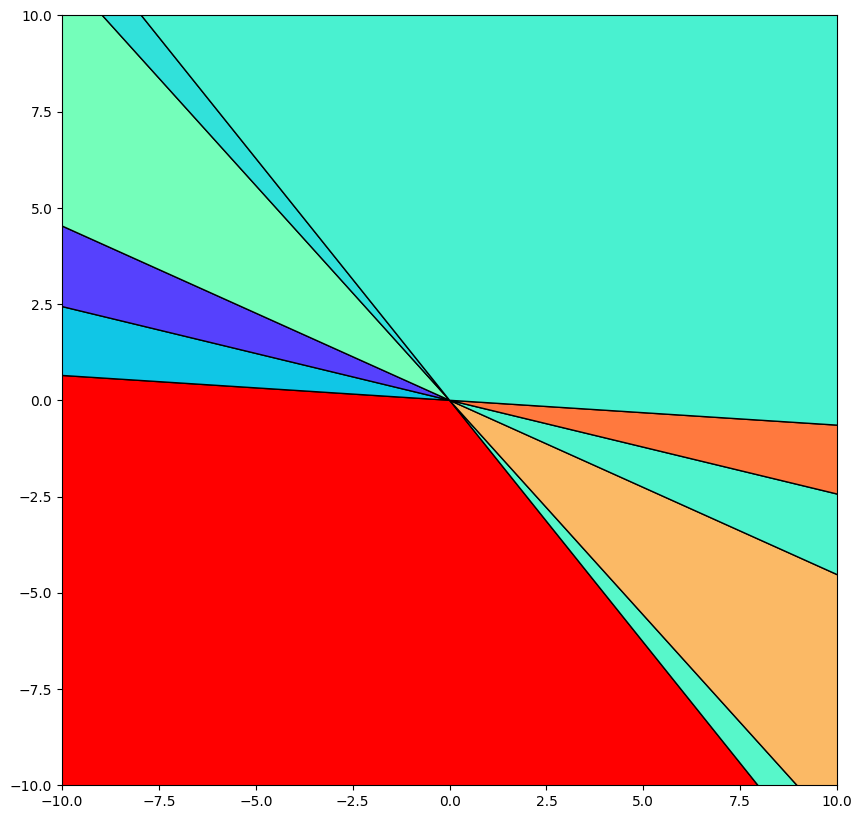

In [722]:
from intvalpy import lineqs
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
colors = [np.random.randint(1, 300) for i in range(len(traversed))]
cmap = matplotlib.colormaps['rainbow']

bound = 92
bounds = [[-bound, -bound], [bound, bound]]
polygons = []
for i, child in enumerate(root.get_children()):
    D = child.Dlw_active
    g = child.glw_active
    
    try:
        # Use a small tolerance or check feasibility first
        verts = lineqs(-D, -g, bounds=bounds, show=False, size=(5,5))
    except (IndexError, ValueError) as e:
        print("Warning: Polytope has no vertices or is empty. Skipping visualization.")
        verts = np.array([]) # Or handle as needed
    
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in verts)
    
    clipped_vertices = clip_vertices(verts.tolist(),bound)
    if vertices_within_boundaries:
        polygon = Polygon(xy=verts, facecolor=cmap(colors[i]), edgecolor="black")
        polygons.append(polygon)

fig, ax = plt.subplots(figsize=(10,10))

for p in polygons:
    ax.add_patch(p)
    # ax.legend()
    ax.set_xlim([-fac, fac])
    ax.set_ylim([-fac, fac])

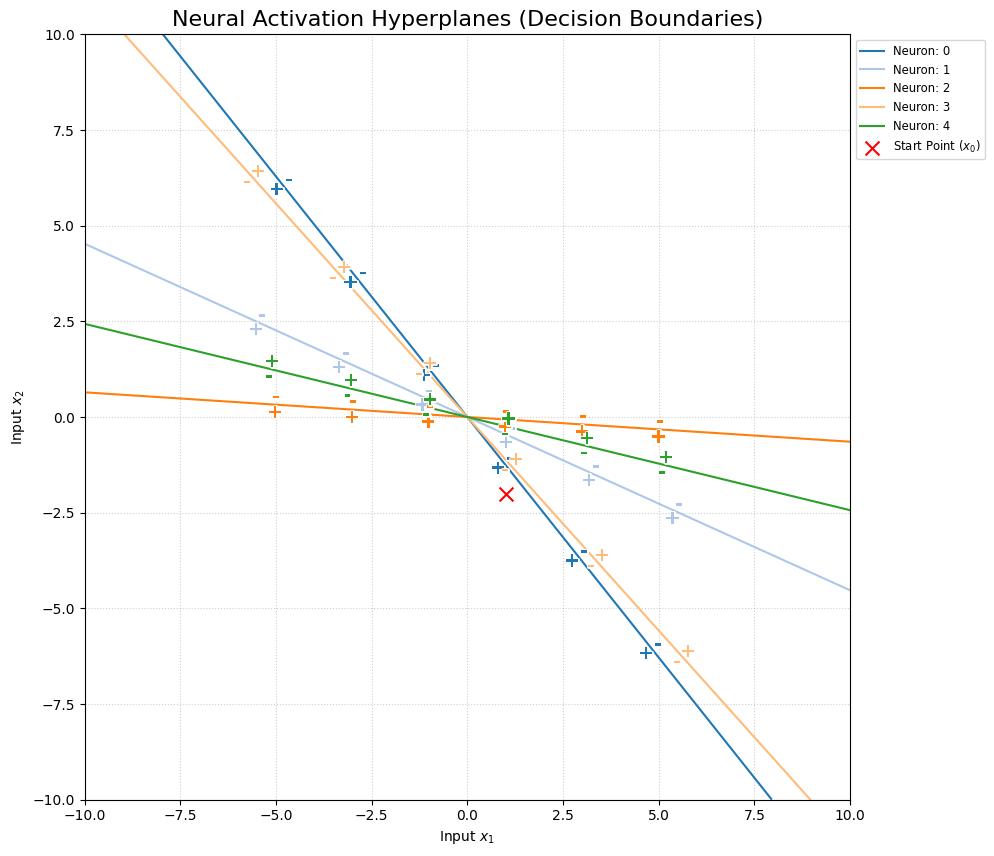

In [723]:
fig, ax = plt.subplots(figsize=(10, 10))
color_pool = cycle(plt.cm.tab20.colors)
# Iterate through weights and biases to plot hyperplanes
for n, (we, be) in enumerate(zip(W1, b1)):
    # Get a real color from the cycle (Crucial fix)
    current_color = next(color_pool)
    
    # We pass a higher offset (e.g., 4.0) because the coordinate space is 200 units wide
    plot_hyperplane(ax, we, be, color=current_color, label=f"Neuron: {n}", offset=fac/50, fac=fac)

# Mark the specific point x0
ax.scatter(x0[0], x0[1], marker="x", color="red", s=100, label="Start Point ($x_0$)", zorder=5)

# Formatting the plot
ax.set_xlim([-fac, fac])
ax.set_ylim([-fac, fac])
ax.set_aspect('equal')
ax.grid(True, linestyle=':', alpha=0.6)

# Move legend outside if there are many neurons
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', ncol=1)

plt.title("Neural Activation Hyperplanes (Decision Boundaries)", fontsize=16)
plt.xlabel("Input $x_1$")
plt.ylabel("Input $x_2$")
plt.tight_layout()
plt.show()

# Deeper Layers, projecting inequalitites

## Focus on one region

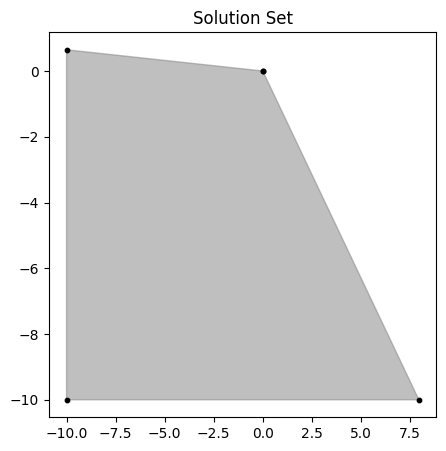

In [724]:
pr = root.get_children()[0]

verts = lineqs(-pr.Dlw_active, -pr.glw_active, bounds=[[-10,-10], [10, 10]], show=True, size=(5,5))

## Find random point within that region


### Mathematical Intuition: Adaptive Interior Point Search

This function finds a point within a polytope defined by $Ax \le b$ by iteratively searching for a feasible region that has been "shrunk" by a safety margin (slack).

#### 1. Geometric Shrinking
The core logic of the function relies on the relationship between a linear constraint and Euclidean distance. A standard constraint is:
$$a_i^T x \le b_i$$

To find a point that is not just on the boundary, but **strictly inside**, we move the boundary inward by a distance $\epsilon$. This is achieved by modifying the offset $b_i$:
$$a_i^T x \le b_i - \epsilon \|a_i\|_2$$



In the code, this is implemented as:
`b_shrunk = b - (current_slack * norms)`

#### 2. Normalization and Distance
The term `norms` ($\|a_i\|_2$) is critical. Without it, the "slack" would be dependent on the scaling of the numbers in the matrix $A$. By multiplying the slack by the $L_2$ norm of each row, we ensure that `current_slack` represents the **actual geometric distance** from the point to the nearest wall of the polytope.

#### 3. The Adaptive Loop (Finding the "Hallway")
A polytope might be very "thin" in some dimensions (like a long, narrow hallway). If the `initial_slack` is larger than half the width of this hallway, the shrunken constraints will cross each other, making the problem infeasible.



The function handles this using an adaptive strategy:
1. **Attempt:** Try to find a point with a high safety margin (`current_slack`).
2. **Failure:** If `linprog` returns `infeasible`, it means the "hallway" is narrower than the requested slack.
3. **Iteration:** Divide the slack by 10 and try again. This effectively "thins" the required safety buffer until the point fits inside the narrowest part of the polytope.

#### 4. Feasibility vs. Optimization
In this specific function, the objective vector $c$ is set to zero:
`c = np.zeros(n)`

This tells the Linear Programming solver that we do not care about maximizing or minimizing a specific coordinate. We only care about **feasibility**—finding any coordinate $x$ that satisfies the shrunken boundaries.

#### 5. Convergence to the Boundary
If the loop reaches the `min_threshold` without success, the function performs one last check with **zero slack**. This determines if the polytope exists at all. If this final check fails, the mathematical conclusion is that the intersection of the half-spaces is empty (the constraints are contradictory).

In [725]:
def get_interior_point_adaptive(A, b, initial_slack=0.1, min_threshold=1e-10, verbose=False):
    """
    Finds a point inside Ax <= b. If min_slack is too large, 
    it recursively tries with smaller slack.
    """
    m, n = A.shape
    
    # Ensure inputs are flat 1D arrays to avoid the Dimension/Shape ValueError
    b = np.asarray(b).flatten()
    norms = np.linalg.norm(A, axis=1).flatten()
    c = np.zeros(n)
    
    current_slack = initial_slack
    
    while current_slack >= min_threshold:
        # Apply the shrinking logic
        b_shrunk = b - (current_slack * norms)
        
        # Try to solve the LP
        res = linprog(c, A_ub=A, b_ub=b_shrunk, 
                      bounds=[(None, None)] * n, 
                      method='highs')
        
        if res.success:
            print(f"Success found with slack: {current_slack}") if verbose else None
            return res.x
        
        # If infeasible, reduce slack and try again
        print(f"Slack {current_slack} too large, trying {current_slack/10}...") if verbose else None
        current_slack /= 10
        
    # Final attempt: try with zero slack (finds any point on/in the boundary)
    res_final = linprog(c, A_ub=A, b_ub=b, bounds=[(None, None)] * n, method='highs')
    if res_final.success:
        return res_final.x
        
    raise ValueError("Polytope is empty or infeasible even with zero slack.")

Success found with slack: 0.1
[[-1.55289302]
 [ 0.        ]]


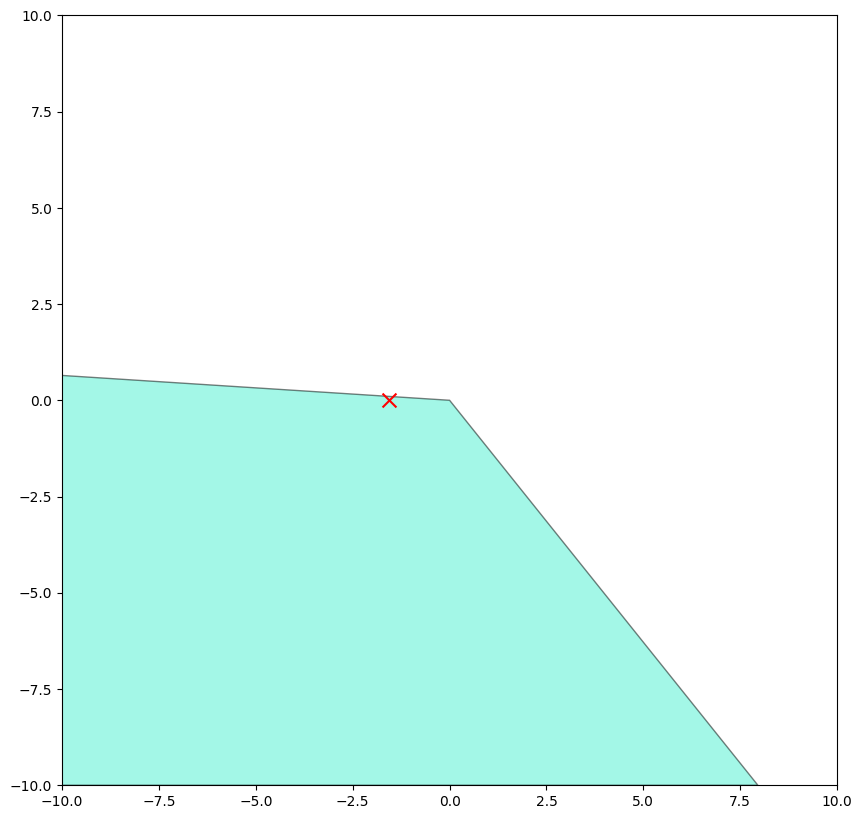

In [726]:
pr.Alw.shape
xx = get_interior_point_adaptive(pr.Dlw_active, pr.glw_active, verbose=True).reshape(-1,1)
xx.shape
pr.Alw.shape


fig, ax = plt.subplots(figsize=(10,10))
p = Polygon(xy=verts, facecolor=cmap(colors[i]), edgecolor="black", alpha=0.5)
ax.add_patch(p)
ax.scatter(xx[0], xx[1], marker="x", color="red", s=100, label="Start Point ($x_0$)", zorder=5)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
print(xx)

## The active constraints of the parent region is called the _global domain_

In [727]:
D_global = pr.Dlw_active
g_global = pr.glw_active

## Activation pattern in respective layer

In [728]:
# Weight and biases of second layer
W2, b2 = get_weigths_and_biases_from_hyperplanes(H, l=2)

In [729]:
qx = find_activation_pattern(xx, W2, b2, pr.Alw, pr.clw)

## Iterate through active bits of this region

In [730]:
 # 1. Initialize
traversed = {}
actives = {} # Dictionary with indices of active neurons for each activation
queue = [to_tuple(qx)]
# traversed[to_tuple(q0)] = True
# TODO: Make this loop a function that takes a parent node
# 2. Process until no new states are found
region_idx = 0
while queue:
    current_key = queue.pop(0)  # Get the next state to process
    current_q = np.array(current_key) 
    
    # Calculate relevant quantities
    S2w = get_sign_matrix(current_q)
    
    # Find local inequalities
    local_hyperplane_slopes = W2 @ pr.Alw
    local_hyperplane_intercepts = W2 @ pr.clw + b2
    D2w = S2w @ local_hyperplane_slopes
    g2w = - S2w @ local_hyperplane_intercepts
    
    
    
    # Find active indices
    local_active_indices, is_bounded = find_active_bits(D2w, g2w, D_global, g_global) 
    actives[current_key] = local_active_indices
    
    # Initialize new region
    new_region = Region(current_q)
    new_region.q_tilde = local_active_indices
    new_region.bounded = is_bounded
    new_region.Dlw = D2w
    new_region.glw = g2w
    new_region.Dlw_active = D2w[list(local_active_indices),:]
    new_region.glw_active = g2w[list(local_active_indices)]
    # new_region.find_active_inequalities()
    
    # Compute projections for that region
    Q2w = np.diag(current_q.ravel())
    new_region.Alw = Q2w @ local_hyperplane_slopes
    new_region.clw = Q2w @ local_hyperplane_intercepts
    
    # Place region in region tree
    new_region.layer_number = 1
    new_region.region_index = region_idx
    region_idx += 1
    pr.add_child(new_region)
    
    print(current_key)
    traversed[current_key] = True
    
    for active_idx in local_active_indices:
        # Generate neighbor
        q_new = current_q.copy()
        q_new[active_idx] ^= 1
        new_key = to_tuple(q_new)
        
        # 3. Only add if we haven't seen it before
        if new_key not in traversed:
            traversed[new_key] = False
            queue.append(new_key)  # Add to queue to be processed in a future loop
            
    # Mark the current one as fully processed
    traversed[current_key] = True

(1, 0, 1, 0)
(0, 0, 1, 0)
(0, 1, 1, 0)


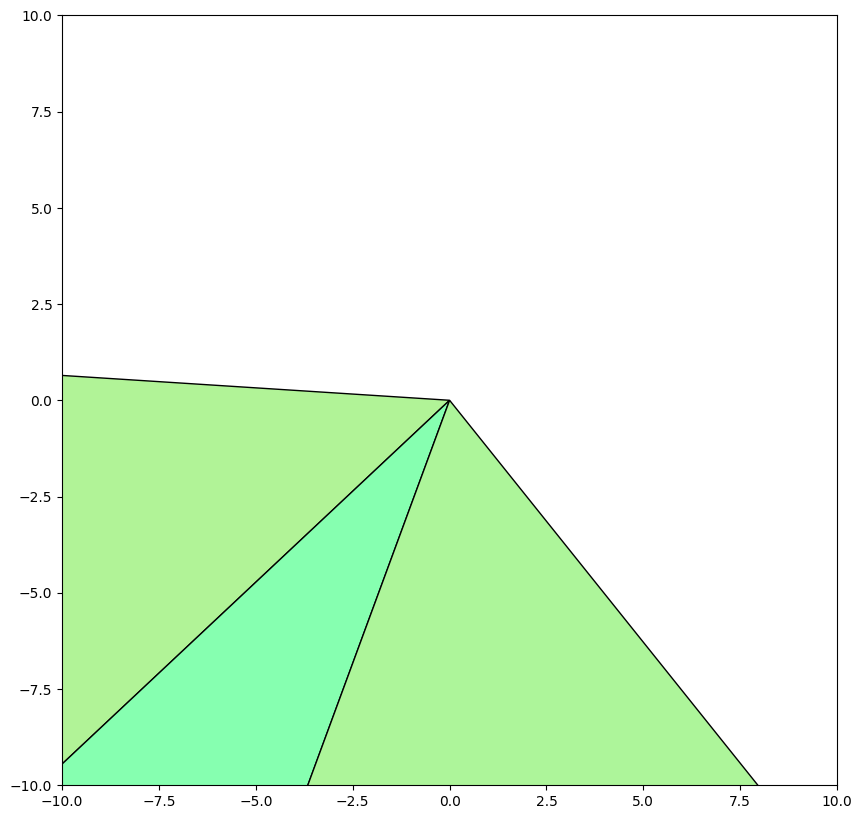

In [731]:
from intvalpy import lineqs
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
colors = [np.random.randint(1, 300) for i in range(len(traversed))]
cmap = matplotlib.colormaps['rainbow']

bound = 92
bounds = [[-bound, -bound], [bound, bound]]
polygons = []
for i, child in enumerate(pr.get_children()):
    D = np.vstack([child.Dlw_active, D_global])
    g = np.vstack([child.glw_active, g_global])
    
    try:
        # Use a small tolerance or check feasibility first
        verts = lineqs(-D, -g, bounds=bounds, show=False, size=(5,5))
    except (IndexError, ValueError) as e:
        print("Warning: Polytope has no vertices or is empty. Skipping visualization.")
        verts = np.array([]) # Or handle as needed
    
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in verts)
    
    clipped_vertices = clip_vertices(verts.tolist(),bound)
    if vertices_within_boundaries:
        polygon = Polygon(xy=verts, facecolor=cmap(colors[i]), edgecolor="black")
        polygons.append(polygon)

fig, ax = plt.subplots(figsize=(10,10))

for p in polygons:
    ax.add_patch(p)
    # ax.legend()
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])

In [732]:
pr.layer_number

1

## Combined from a parent node

In [733]:
def find_subregions(parent):
    
    # Find point
    x = get_interior_point_adaptive(parent.Dlw_active, parent.glw_active, verbose=True).reshape(-1,1)
    
    # Global contraints
    D_global = parent.Dlw_active
    g_global = parent.glw_active
    
    # Weight and biases of parent layer +1
    layer = parent.layer_number + 1
    Wl, bl = get_weigths_and_biases_from_hyperplanes(H, l=layer)
    
    # Find activation of point
    q0 = find_activation_pattern(x, Wl, bl, parent.Alw, parent.clw)
    
     # 1. Initialize
    traversed = {}
    actives = {} # Dictionary with indices of active neurons for each activation
    queue = [to_tuple(q0)]
    # traversed[to_tuple(q0)] = True
    # TODO: Make this loop a function that takes a parent node
    # 2. Process until no new states are found
    region_idx = 0
    while queue:
        current_key = queue.pop(0)  # Get the next state to process
        current_q = np.array(current_key) 
        
        # Calculate relevant quantities
        Slw = get_sign_matrix(current_q)
        
        # Find local inequalities
        local_hyperplane_slopes = Wl @ parent.Alw
        local_hyperplane_intercepts = Wl @ parent.clw + bl
        Dlw = Slw @ local_hyperplane_slopes
        glw = - Slw @ local_hyperplane_intercepts
        
        
        
        # Find active indices
        local_active_indices, is_bounded = find_active_bits(Dlw, glw, D_global, g_global) 
        actives[current_key] = local_active_indices
        
        # Initialize new region
        new_region = Region(current_q)
        new_region.q_tilde = local_active_indices
        new_region.bounded = is_bounded
        new_region.Dlw = Dlw
        new_region.glw = glw
        new_region.Dlw_active = Dlw[list(local_active_indices),:]
        new_region.glw_active = glw[list(local_active_indices)]
        # new_region.find_active_inequalities()
        
        # Compute projections for that region
        Qlw = np.diag(current_q.ravel())
        new_region.Alw = Qlw @ local_hyperplane_slopes
        new_region.clw = Qlw @ local_hyperplane_intercepts
        
        # Place region in region tree
        new_region.layer_number = layer
        new_region.region_index = region_idx
        region_idx += 1
        parent.add_child(new_region)
        
        print(current_key)
        traversed[current_key] = True
        
        for active_idx in local_active_indices:
            # Generate neighbor
            q_new = current_q.copy()
            q_new[active_idx] ^= 1
            new_key = to_tuple(q_new)
            
            # 3. Only add if we haven't seen it before
            if new_key not in traversed:
                traversed[new_key] = False
                queue.append(new_key)  # Add to queue to be processed in a future loop
                
        # Mark the current one as fully processed
        traversed[current_key] = True
        
parents = root.get_children()
for parent in parents:
    find_subregions(parent)
    

Success found with slack: 0.1
(1, 0, 1, 0)
(0, 0, 1, 0)
(0, 1, 1, 0)
Success found with slack: 0.1
(0, 1, 1, 0)
Success found with slack: 0.1
(1, 0, 1, 0)
Success found with slack: 0.1
(0, 1, 1, 0)
(0, 1, 0, 0)
Success found with slack: 0.1
(0, 0, 1, 0)
(1, 0, 1, 0)
(0, 1, 1, 0)
Success found with slack: 0.1
(0, 1, 0, 0)
Success found with slack: 0.1
(0, 1, 0, 0)
(0, 1, 1, 0)
Success found with slack: 0.1
(0, 1, 0, 0)
Success found with slack: 0.1
(0, 1, 0, 0)
Success found with slack: 0.1
(0, 1, 0, 0)


In [734]:
parents[2].get_children()

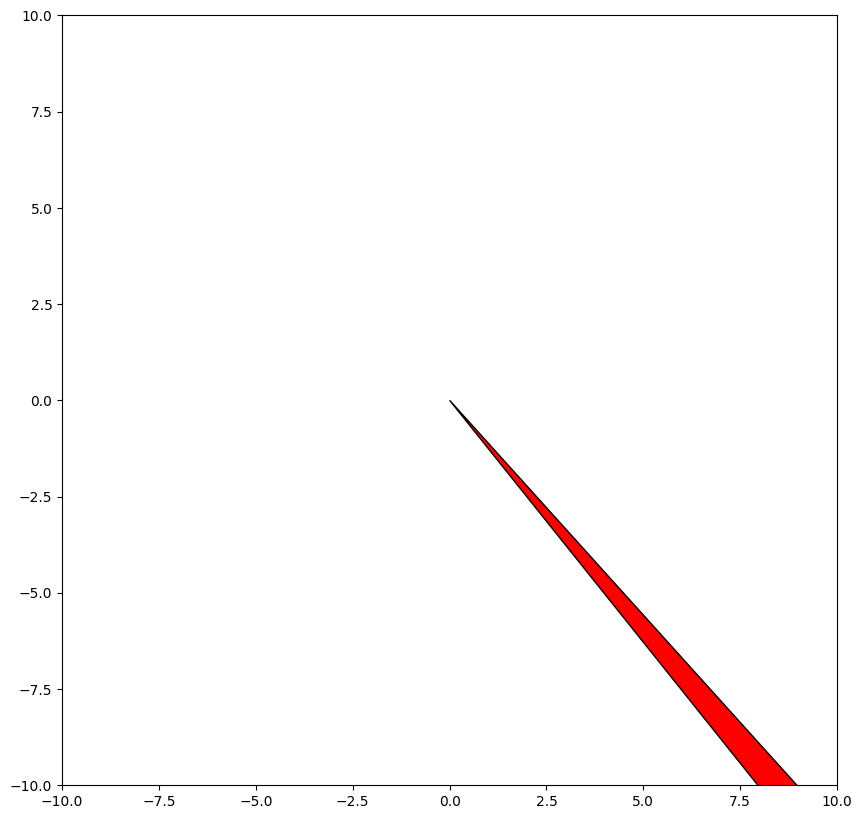

In [736]:
from intvalpy import lineqs
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
colors = [np.random.randint(1, 300) for i in range(len(traversed))]
cmap = matplotlib.colormaps['rainbow']

bound = 92
bounds = [[-bound, -bound], [bound, bound]]
polygons = []
for i, child in enumerate(parents[1].get_children()):
    D = np.vstack([child.Dlw_active, child.parent.Dlw_active])
    g = np.vstack([child.glw_active, child.parent.glw_active])
    
    try:
        # Use a small tolerance or check feasibility first
        verts = lineqs(-D, -g, bounds=bounds, show=False, size=(5,5))
    except (IndexError, ValueError) as e:
        print("Warning: Polytope has no vertices or is empty. Skipping visualization.")
        verts = np.array([]) # Or handle as needed
    
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in verts)
    
    clipped_vertices = clip_vertices(verts.tolist(),bound)
    if vertices_within_boundaries:
        polygon = Polygon(xy=verts, facecolor=cmap(colors[i]), edgecolor="black")
        polygons.append(polygon)

fig, ax = plt.subplots(figsize=(10,10))

for p in polygons:
    ax.add_patch(p)
    # ax.legend()
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])